In [76]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import random
from pprint import pprint
from sklearn import metrics

In [77]:
def get_data(df,test_ratio):

  df1 = df[df["label"] ==1]
  df2 = df[df["label"] ==0]
  
  train1, test1 = train_test_split(df1, random_state=91,test_size=test_ratio)
  train2, test2 = train_test_split(df2, random_state=91,test_size=test_ratio)
  
  train_df=pd.concat([train1, train2], axis=0)
  test_df=pd.concat([test1, test2], axis=0)

  return train_df,test_df

In [78]:
def check_purity(data):                 #function to check purity 
  label_column=data[:,-1]
  unique_classes=np.unique(label_column)

  if len(unique_classes)==1:
    return True
  else:
    return False

In [79]:
def classify_data(data):

  label_column=data[:,-1]
  unique_classes, counts_unique_classes=np.unique(label_column, return_counts=True)

  index=counts_unique_classes.argmax()
  classification=unique_classes[index]

  return classification

In [80]:
def get_potential_splits(data,random_subspace):             #calculating all potential splits in the data colunm wise and storing in  a vector
    
    potential_splits = {}
    _, n_columns = data.shape
    column_indices = list(range(n_columns - 1))    # excluding the last column which is the label
    
    if random_subspace and random_subspace <= len(column_indices):
        column_indices = random.sample(population=column_indices, k=random_subspace)
    
    for column_index in column_indices:          
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        potential_splits[column_index] = unique_values
    
    return potential_splits

In [81]:
def split_data(data, split_column, split_value):          #function to split data at each decision
    
    split_column_values = data[:, split_column]

    data_below = data[split_column_values <= split_value]
    data_above = data[split_column_values >  split_value]
    
    return data_below, data_above

In [82]:
def calculate_entropy(data):                                  #function to calculate entropy of node in the tree
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

In [83]:
def calculate_overall_entropy(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    if n==0:
      return 0;
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below) 
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy

In [84]:
def determine_best_split(data, potential_splits):                     #selecting the best split by checking information gain
    
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

In [85]:
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=10,random_subspace=None):      #recursive decision tree algorithm
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = df.columns
        data = df.values
    else:
        data = df           
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification

    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data, random_subspace)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        if len(data_below) == 0 or len(data_above) == 0:
            classification = classify_data(data)
            return classification
        
        # determine question
        question = "{} <= {}".format(COLUMN_HEADERS[split_column], split_value)
  
        # instantiate sub-tree
        sub_tree = {question: []}
        
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth, random_subspace)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth, random_subspace)
    
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

In [86]:
def predict_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":
        if example[int(feature_name)] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)

In [87]:
def decision_tree_predictions(test_df, tree):
    predictions=[]
    predictions = test_df.apply(predict_example,  axis=1,args=(tree,))
    return predictions

In [88]:
def calculate_accuracy(predictions, labels):
    predictions_correct = predictions == labels
    accuracy =100* predictions_correct.mean()
    
    return accuracy

In [89]:
def bootstrapping(train_df, n_bootstrap):
    bootstrap_indices = np.random.randint(low=0, high=len(train_df), size=n_bootstrap)
    df_bootstrapped = train_df.iloc[bootstrap_indices]
    
    return df_bootstrapped

def random_forest_algorithm(train_df, n_trees, n_bootstrap, n_features, dt_max_depth):
    forest = []
    for i in range(n_trees):
        df_bootstrapped = bootstrapping(train_df, n_bootstrap)
        tree = decision_tree_algorithm(df_bootstrapped, max_depth=dt_max_depth, random_subspace=n_features)
        forest.append(tree)
    
    return forest

def random_forest_predictions(test_df, forest):
    df_predictions = {}
    for i in range(len(forest)):
        column_name = "tree_{}".format(i)
        predictions = decision_tree_predictions(test_df, tree=forest[i])
        df_predictions[column_name] = predictions

    df_predictions = pd.DataFrame(df_predictions)
    random_forest_predictions = df_predictions.mode(axis=1)[0]
    
    return random_forest_predictions

In [90]:
#getting data
data = pd.read_csv('https://web.stanford.edu/~hastie/ElemStatLearn//datasets/spam.data', sep=" ",header=None) 
data=data.rename(columns={len(data.columns)-1:"label"})
train_df, test_df = get_data(data, test_ratio=0.2)

In [91]:
#predictions and accuracy

forest = random_forest_algorithm(train_df, n_trees=8, n_bootstrap=800, n_features=40, dt_max_depth=10)
predictions = random_forest_predictions(test_df, forest)
accuracy = calculate_accuracy(predictions, test_df.label)

print("Accuracy = {} ".format(accuracy))

Accuracy = 91.42236699239956 


In [99]:
target_names=[0,1]
predicts=(predictions.to_numpy()).astype(int)
classification_report(y_test, predicts)
metrics.precision_score(y_test, predicts)
metrics.recall_score(y_test, predicts)
print("Accuracy = {} ".format(accuracy))

Accuracy = 91.42236699239956 


In [103]:
#for inbuilt classifier

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

train_X_df=train_df.drop(['label'],axis=1)
test_X_df=test_df.drop(['label'],axis=1)

X_train=train_X_df.to_numpy()
y_train=train_df['label'].to_numpy()
X_test=test_X_df.to_numpy()
y_test=test_df['label'].to_numpy()

clf = RandomForestClassifier(n_estimators = 8,criterion='entropy',max_depth=10,max_features=10,max_samples=800)
clf.fit(X_train, y_train)
print(100*clf.score(X_test, y_test))

92.94245385450597


In [107]:
def print_accuracies(train_df) : #print acurracies for all m
  accuracies=[]
  for i in range(train_df.shape[1]):
    forest = random_forest_algorithm(train_df, n_trees=7, n_bootstrap=500, n_features=i, dt_max_depth=7)
    predictions = random_forest_predictions(test_df, forest)
    accuracy = calculate_accuracy(predictions, test_df.label)
    accuracies.append(accuracy)
    print(accuracy)


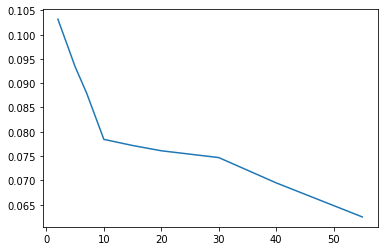

In [108]:
#plotting test error
import matplotlib.pyplot as plt
m=[2,5,7,10,15,20,30,40,55]
test_error=[]
Accuracies=[89.68512486427795,90.66232356134635,91.20521172638436,92.15667752442996,92.28241042345277,92.39098805646036,92.53094462540716,93.05103148751357,93.75193128751357]
for i in Accuracies:
  test_error.append((100-i)/100)

plt.plot(m,test_error)
plt.show()